In [1]:
import os
import sys
from pathlib import Path
import time
from pyglet.window import key
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import_path = str(Path(os.getcwd()).parent.parent)
sys.path.insert(0, import_path)

from WorldModelsExperiments.breakout.model import Model, make_model, _process_frame

/home/dakaun/PycharmProjects/world_model/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dakaun/PycharmProjects/world_model/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dakaun/PycharmProjects/world_model/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dakaun/

In [3]:
path = '/home/dakaun/Dropbox/MA/worldmodel/worldmodel-breakout-server-version-v3/200420'
rnn_path = path + '/tf_rnn/rnn.json'
vae_path = path + '/tf_vae/vae.json'
controller_path = path + '/log/breakout.cma.16.32.best.json'

render_mode = True
use_model = True

In [4]:
model = make_model(rnn_path=rnn_path, vae_path=vae_path)
model.load_model(controller_path)

INFO:tensorflow:Model using cpu.
loading file /home/dakaun/Dropbox/MA/worldmodel/worldmodel-breakout-server-version-v3/200420/log/breakout.cma.16.32.best.json


In [5]:
reward_list = []
obs_sequence = np.zeros(shape=(10000,210,160,3), dtype=np.uint8)
tsne_data = pd.DataFrame()

global human_sets_pause, key_to_action
human_sets_pause = False
num_episode = 1

In [6]:
def key_press(symbol, mod):
    global human_sets_pause
    if symbol == key.SPACE:
        human_sets_pause = not human_sets_pause

#### Start normal game until pause manually

In [7]:
for episode in range(num_episode):
    total_reward = 0
    obs = model.env.reset()
    done = False
    seq_counter = 0
    
    while not done:
        model.env.render('human')
        model.env.unwrapped.viewer.window.on_key_press = key_press
        
        obs = _process_frame(obs)
        z, mu, logvar = model.encode_obs(obs)
        _, action = model.get_action(z)
        obs, reward, done, info = model.env.step(action)
        
        data = np.concatenate([z, model.state.h[0]]).reshape(1,288)
        tsne_data = tsne_data.append(pd.DataFrame(data), ignore_index=True)
        obs_sequence[seq_counter,:,:,:] = obs
        total_reward += reward
        seq_counter += 1
        
        if human_sets_pause:
            time.sleep(1)
            print('render for several steps done, shift with current reward: ', total_reward)
            time.sleep(2)
            human_sets_pause= False
            model.env.viewer.close()
            model.env.viewer = None
            print('close env')
            break
            
        
    if done:
        print('game episode ', str(episode), ' is done with total reward: ', total_reward)
        if render_mode:
            model.env.viewer.close()
            model.env.viewer = None
            #model.env.close()
            print('close env')
    time.sleep(2)

render for several steps done, shift with current reward:  2.0
close env


#### Video Sequence

In [17]:
import base64
import imageio
import IPython
from PIL import Image

In [18]:
def embed_mp4(filename,video):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [19]:
filename = 'obs_sequence.mp4'
with imageio.get_writer(filename, mode='I', macro_block_size=None) as video:    
    for image in range(seq_counter):
        video.append_data(obs_sequence[image])
embed_mp4(filename,video)

In [8]:
# PAUSE STATUS
pause_seq_counter = seq_counter
pause_state = model.state
pause_obs = obs
pause_sequence=obs_sequence[:pause_seq_counter,:,:,:]
pause_reward = total_reward
pause_gamestatus = model.env.clone_full_state()
pause_z = z

In [9]:
print('Pause reward', pause_reward)
pause_sequence.shape

Pause reward 2.0


(178, 210, 160, 3)

#### OPTION 1 : Continue game NORMAL

In [15]:
#OPTION 1: NORMAL
# todo add several black images to simulate pause
obs_normal = np.zeros(shape=(3000,210,160,3), dtype=np.uint8)
obs_normal[:pause_seq_counter]= pause_sequence
seq_counter = pause_seq_counter +4
total_reward = pause_reward
obs = pause_obs
model.state = pause_state
model.env.restore_full_state(pause_gamestatus)
done = False

while not done and seq_counter<3000:
    obs = _process_frame(obs)
    z, mu, logvar = model.encode_obs(obs)
    _, action = model.get_action(z)
    obs, reward, done, info = model.env.step(action)
    model.env.render('human')
    
    obs_normal[seq_counter,:,:,:] = obs
    total_reward += reward
    seq_counter +=1
    if seq_counter == (pause_seq_counter+5):
        print(seq_counter)
        z_normal = z
        state_normal = model.state
        action_normal = action

print('Episode is done with total reward: ', total_reward)
model.env.viewer.close()
model.env.viewer = None

183
Episode is done with total reward:  4.0


In [23]:
filename = 'obs_sequence_normal.mp4'
with imageio.get_writer(filename, mode='I', macro_block_size=None) as video:    
    for image in range(seq_counter):
        video.append_data(obs_normal[image])
embed_mp4(filename,video)

#### OPTION 2 : Continue game SHIFT TO RIGHT

In [25]:
#OPTION 2: RIGHT
obs_right = np.zeros(shape=(3000,210,160,3), dtype=np.uint8)
obs_right[:pause_seq_counter]= pause_sequence
seq_counter = pause_seq_counter +4
total_reward = pause_reward
model.state = pause_state
model.env.restore_full_state(pause_gamestatus)
done = False

for i in range(20):
    obs, _, _, _ = model.env.step(2)
#todo state auch updaten ? 

obs_right[seq_counter,:,:,:]=obs
seq_counter +=1

while not done:
    obs = _process_frame(obs)
    z, mu, logvar = model.encode_obs(obs)
    _, action = model.get_action(z)
    obs, reward, done, info = model.env.step(action)
    model.env.render('human')
    
    obs_right[seq_counter,:,:,:] = obs
    total_reward += reward
    seq_counter +=1

print('Episode is done with total reward: ', total_reward)
model.env.viewer.close()
model.env.viewer = None

Episode is done with total reward:  4.0


In [26]:
filename = 'obs_sequence_right.mp4'
with imageio.get_writer(filename, mode='I', macro_block_size=None) as video:    
    for image in range(seq_counter):
        video.append_data(obs_right[image])
embed_mp4(filename,video) 

#### OPTION 3 : Continue game SHIFT TO LEFT

In [27]:
#OPTION 3: LEFT
obs_left = np.zeros(shape=(3000,210,160,3), dtype=np.uint8)
obs_left[:pause_seq_counter]= pause_sequence
seq_counter = pause_seq_counter +4
total_reward = pause_reward
model.state = pause_state
model.env.restore_full_state(pause_gamestatus)
done = False

for i in range(20):
    obs, _, _, _ = model.env.step(3)
#todo state auch updaten ? 

obs_left[seq_counter,:,:,:]=obs
seq_counter +=1

while not done:
    obs = _process_frame(obs)
    z, mu, logvar = model.encode_obs(obs)
    _, action = model.get_action(z)
    obs, reward, done, info = model.env.step(action)
    model.env.render('human')
    
    obs_left[seq_counter,:,:,:] = obs
    total_reward += reward
    seq_counter +=1

print('Episode is done with total reward: ', total_reward)
model.env.viewer.close()
model.env.viewer = None

Episode is done with total reward:  5.0


In [28]:
filename = 'obs_sequence_left.mp4'
with imageio.get_writer(filename, mode='I', macro_block_size=None) as video:    
    for image in range(seq_counter):
        video.append_data(obs_left[image])
embed_mp4(filename,video) 

In [29]:
obs_normal.shape

(3000, 210, 160, 3)

In [30]:
obs_left.shape

(3000, 210, 160, 3)

In [31]:
obs_right.shape

(3000, 210, 160, 3)

In [32]:
all_images = np.concatenate((obs_left, obs_normal, obs_right), axis=2)
all_images.shape

(3000, 210, 480, 3)

In [34]:
img = Image.fromarray(all_images[0])
img.show()

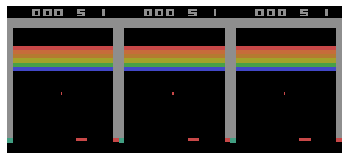

In [38]:
plt.imshow(all_images[0])
plt.axis('off')
plt.show()

In [39]:
filename = 'obs_sequence_all.mp4'
with imageio.get_writer(filename, mode='I', macro_block_size=None) as video:    
    for image in range(len(all_images)):
        video.append_data(all_images[image])
embed_mp4(filename,video) 

### Compare z, state in different options

In [ ]:
pause_state, pause_z

In [18]:
xinput = np.concatenate([z, pause_state.h[0]])

In [29]:
action_normal

3

links (auch normal)

In [20]:
A_3 = [xinput] + [None]
A_3[1] = np.maximum(0,A_3[0].dot(model.weight) + model.bias)

In [21]:
R_3 = [None] + [A_3[1]*(3==np.arange(4))]

w = model.weight
wp = np.maximum(0,w)
wm = np.minimum(0,w)
lb = A_3[0]*0-1
hb = A_3[0]*0+1

z = A_3[0].dot(w)-lb.dot(wp)-hb.dot(wm)+1e-9
s = R_3[1]/z
c, cp, cm = s.dot(w.T), s.dot(wp.T), s.dot(wm.T)
R_3[0] = A_3[0]*c-lb*cp-hb*cm

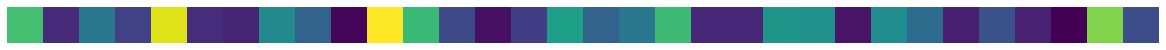

In [28]:
plt.figure(figsize=(16,5))
plt.subplots_adjust(left=0,right=1,bottom=0,top=1)
plt.axis('off')
plt.imshow(R_3[0][:32].reshape(1,32))
plt.show()

rechts

In [30]:
A_2 = [xinput] + [None]
A_2[1] = np.maximum(0,A_2[0].dot(model.weight) + model.bias)

In [31]:
R_2 = [None] + [A_2[1]*(2==np.arange(4))]

w = model.weight
wp = np.maximum(0,w)
wm = np.minimum(0,w)
lb = A_2[0]*0-1
hb = A_2[0]*0+1

z = A_2[0].dot(w)-lb.dot(wp)-hb.dot(wm)+1e-9
s = R_2[1]/z
c, cp, cm = s.dot(w.T), s.dot(wp.T), s.dot(wm.T)
R_2[0] = A_2[0]*c-lb*cp-hb*cm

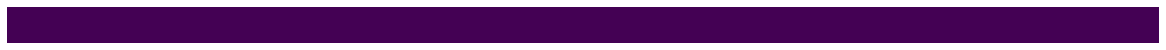

In [32]:
plt.figure(figsize=(16,5))
plt.subplots_adjust(left=0,right=1,bottom=0,top=1)
plt.axis('off')
plt.imshow(R_2[0][:32].reshape(1,32))
plt.show()